<a href="https://colab.research.google.com/github/LeeYuuuan/Graph-Kernel-Isomorphic-/blob/main/TUDatasetAnalsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# add dependencies

In [ ]:
%pip install grakel
import grakel
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import networkx.algorithms.isomorphism as iso
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score



# Draw Graph

In [ ]:
def draw_graphs(Gra1,Gra2):
    pos = nx.spring_layout(Gra1)
    pos1 = nx.spring_layout(Gra2) 
    plt.subplot(121)
    nx.draw(Gra1, pos, with_labels=True, node_color='pink', node_size=500)
    plt.subplot(122)
    nx.draw(Gra2, pos1, with_labels=True, node_size=500)
    plt.show()

# Load Data

In [ ]:
def GetGraphData(dataset_name):
    dataset = grakel.datasets.fetch_dataset(dataset_name, verbose=True, data_home=None, download_if_missing=True, with_classes=True, produce_labels_nodes=False, prefer_attr_nodes=False, prefer_attr_edges=False, as_graphs=False)
    G = dataset.data
    y = dataset.target
    return G, y

In [ ]:
def GetGraph(an_old_graph):
    """
    This function input a graph from /grakel dataset/
    Then converted to a type [class]Graph (networkx)
    """
    Graph = nx.MultiGraph()
    Graph.add_edges_from(list(an_old_graph[0]))

    if len(an_old_graph[1]) != 0:
      for node in an_old_graph[1]:
        Graph.add_node(node, attr=an_old_graph[1][node])
    if len(an_old_graph[2]) !=0:
      for edge in an_old_graph[2]:
        Graph.add_edge(edge[0],edge[1], attr=an_old_graph[2][edge])
  
    return Graph

In [ ]:
def GetGraphwithoutLabel(an_old_graph):
    """
    This function input a graph from /grakel dataset/
    Then converted to a type [class]Graph (networkx) 
    NOTE: without labels.
    """
    Graph = nx.MultiGraph()
    Graph.add_edges_from(list(an_old_graph[0]))

    return Graph

In [ ]:
def GetAllGraph(graph_dataset):
    """
    Get all Graph with type of [class]Graph
    return a list [Graph1, Graph2, ...]
    """
    Graphs = []
    for graph_data in graph_dataset:
      Graphs.append(GetGraph(graph_data))
    
    return Graphs

In [ ]:
def GetAllGraphwithoutLables(graph_dataset):
    """
    Get all Graph with type of [class]Graph
    return a list [Graph1, Graph2, ...]
    """
    Graphs = []
    for graph_data in graph_dataset:
      Graphs.append(GetGraphwithoutLabel(graph_data))
    
    return Graphs

# Analysis 

In [ ]:
def GetSumCount(Graphs):
    """
    Get the number of the graphs in the dataset.
    """
    return len(Graphs)

In [ ]:
def GetAverageNodes(Graphs):
    """
    Get the average number of nodes for a certain dataset.
    """
    sum = 0
    for Graph in Graphs:
        sum += len(Graph.nodes())
    
    return sum/len(Graphs)


In [ ]:
def GetAverageEdges(Graphs):
    """
    Get the average number of edges for a certain dataset.
    """
    sum = 0
    for Graph in Graphs:
        sum += len(Graph.edges())
    
    return sum/len(Graphs)/2


In [ ]:
def GetMaxandMinNode(Graphs):
    """
    Get the max and min number of nodes in Graphs.
    """
    max_number = - 1
    min_number = 999999
    for Graph in Graphs:
        if len(Graph.nodes()) < min_number:
            min_number = len(Graph.nodes())
        
        if len(Graph.nodes()) > max_number:
            max_number = len(Graph.nodes())
  

    return [max_number, min_number]

In [ ]:
def GetSummary(name):
    """
    Get the summary statisic information for a certain Dataset.

    or Get for a list of Datasets.
    """
    if type(name) == str :
        G,y = GetGraphData(name)
        Graphs = GetAllGraph(G)
        df = pd.DataFrame(columns=["Name","Graphs","Class","Average Nodes", "Average Edges", "Max number of nodes", "Min number of nodes"])
        temp_df = {"Name": name, 
                   "Graphs": GetSumCount(Graphs), 
                   "Class": len(set(y)), 
                   "Average Nodes": GetAverageNodes(Graphs),
                   "Average Edges": GetAverageEdges(Graphs),
                   "Max number of nodes": GetMaxandMinNode(Graphs)[0],
                   "Min number of nodes": GetMaxandMinNode(Graphs)[1]
                   }
        df = df.append([temp_df], ignore_index=True)
        # df.loc[0] = [name, GetSumCount(Graphs), len(set(y)), GetAverageNodes(Graphs)]
    elif type(name) == list:
        df = pd.DataFrame(columns=["Name","Graphs","Class","Average Nodes", "Average Edges", "Max number of nodes", "Min number of nodes"])
        for dataset in name:
            G,y = GetGraphData(dataset)
            Graphs = GetAllGraph(G)
            
            temp_df = {"Name": dataset, 
                   "Graphs": GetSumCount(Graphs), 
                   "Class": len(set(y)), 
                   "Average Nodes" : GetAverageNodes(Graphs),
                   "Average Edges" : GetAverageEdges(Graphs),
                   "Max number of nodes": GetMaxandMinNode(Graphs)[0],
                   "Min number of nodes": GetMaxandMinNode(Graphs)[1]
                   }
            df = df.append(temp_df, ignore_index=True)
        



    return df

In [ ]:
def IsIsomorphicDefault(G1,G2,is_node_labeled,is_edge_labeled):
  """
  Input two Graphs G1, G2,
  Input True/False if Node/edge is labeled or not.

  return True/False if two Graphs is isomorphic or not.
  """
  if is_node_labeled:
    nm = iso.numerical_node_match("attr",0)
    if is_edge_labeled:
      em = iso.numerical_edge_match("attr",-1)
      GM = iso.GraphMatcher(G1, G2, node_match=nm, edge_match=em)
    else:
      GM = iso.GraphMatcher(G1, G2, node_match=nm)
  else:
    if is_edge_labeled:
      em = iso.numerical_edge_match("attr",-1)
      GM = iso.GraphMatcher(G1, G2, edge_match=em)
    else:
      GM = iso.GraphMatcher(G1, G2)
  
  return np.float64(GM.is_isomorphic())


In [ ]:
def CreateFeatureMatrix(graphs,is_node_labeled,is_edge_labeled):
    feature_matrix = np.zeros([len(graphs),len(graphs)])
    for i in range(len(graphs)):
      for j in range(len(graphs)):
        feature_matrix[i,j] = IsIsomorphicDefault(graphs[i],graphs[j],is_node_labeled,is_edge_labeled)
   
  
    return feature_matrix


In [ ]:
def GetIsomorphicFeatureMatrix(dataset_name,is_node_labeled,is_edge_labeled):
    G, y = GetGraphData(dataset_name)
    all_graph = GetAllGraph(G)
    return CreateFeatureMatrix(all_graph,is_node_labeled,is_edge_labeled), y
  

In [ ]:

def DrawIsomorphicMatrix(dataset_name, is_node_labeled, is_edge_labeled):

    sumIso = 0
    fm, y = GetIsomorphicFeatureMatrix(dataset_name,is_node_labeled,is_edge_labeled)
            
    plt.matshow(fm)
    print("there are ",(np.sum(fm) - fm.shape[0])/2, "pairs of graphs isomorphiced" )



## BZR

In [ ]:
G,y = GetGraphData("BZR")
Graphs_BZR = GetAllGraph(G)
GraphswitoutLabel_BZR = GetAllGraphwithoutLables(G)

# Statistic

In [ ]:
GetSummary(['BZR', 'COX2', 'DHFR', 'PTC_FM', 'PTC_FR', 'PTC_MM', 'PTC_MR','IMDB-BINARY', 'MSRC_9', 'MSRC_21', 'MSRC_21C'])

Extracting dataset  BZR..
Parsing dataset  BZR..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
Extracting dataset  COX2..
Parsing dataset  COX2..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
Extracting dataset  DHFR..
Parsing dataset  DHFR..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
Extracting dataset  PTC_FM..
Parsing dataset  PTC_FM..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
Extracting dataset  PTC_FR..
Parsing dataset  PTC_FR..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
Extracting dataset  PTC_MM..
Parsing dataset  PTC_MM..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
Extracting dataset  PTC_MR..
Parsing dataset  PTC_MR..
Parse was succesful..
Deleting unzipped dataset files..
Goi

,Name,Graphs,Class,Average Nodes,Average Edges,Max number of nodes,Min number of nodes
0,BZR,405,2,35.750617,38.358025,57,13
1,COX2,467,2,41.224839,43.445396,56,32
2,DHFR,756,2,42.427249,44.544974,71,20
3,PTC_FM,349,2,14.111748,28.968481,64,2
4,PTC_FR,351,2,14.558405,30.005698,64,2
5,PTC_MM,336,2,13.973214,28.642857,64,2
6,PTC_MR,344,2,14.287791,29.383721,64,2
7,IMDB-BINARY,1000,2,19.773000,96.531000,136,12
8,MSRC_9,221,8,40.579186,97.936652,55,25
9,MSRC_21,563,20,77.520426,198.323268,141,51


In [ ]:
def GetNodeDistribution(dataset_name):
    """
    draw the node distribution histogram.
    """
    G,y = GetGraphData(dataset_name)
    Graphs = GetAllGraph(G)
    node_count = []

    for graph in Graphs:
        node_count.append(len(graph.nodes()))
    

    label_bins = len(np.unique(y))

    max_nodes = GetMaxandMinNode(Graphs)[0]
    print("VISUALIZATIONS:\nMax nodes in consideration: {}".format(max_nodes))
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    
    plt.hist(node_count, bins=len(np.unique(node_count)))
    plt.xlabel('Number of Nodes in Graph', fontsize=12)
    plt.ylabel('Count', fontsize=12)

    plt.subplot(122)
    plt.hist2d(y, node_count, bins=[label_bins, 20])
    plt.xlabel(r'Graph label', fontsize=12)
    plt.ylabel(r'Graph size (number of nodes)', fontsize=12)
    plt.colorbar()
    plt.show()
    
    print("Correlation between graph size (number of nodes) and labels: %.2f" % np.corrcoef(y, node_count)[0,1])

Extracting dataset  BZR..
Parsing dataset  BZR..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
VISUALIZATIONS:
Max nodes in consideration: 57


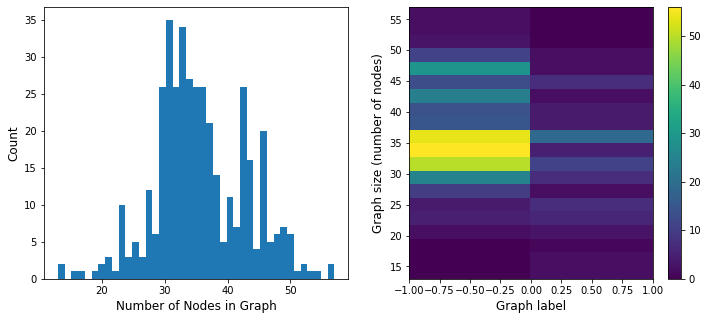

Correlation between graph size (number of nodes) and labels: -0.22


In [ ]:
GetNodeDistribution("BZR")

Extracting dataset  COX2..
Parsing dataset  COX2..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
VISUALIZATIONS:
Max nodes in consideration: 56


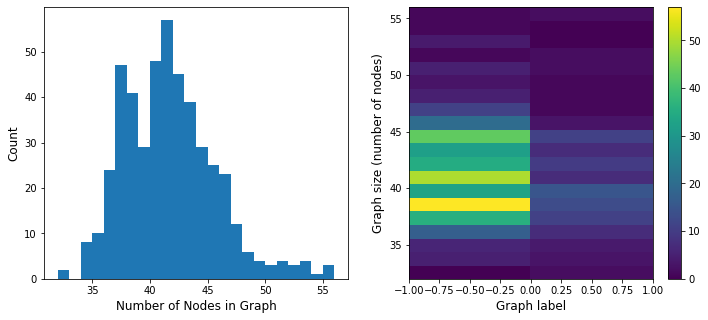

Correlation between graph size (number of nodes) and labels: -0.06


In [ ]:
GetNodeDistribution("COX2")

Extracting dataset  DHFR..
Parsing dataset  DHFR..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
VISUALIZATIONS:
Max nodes in consideration: 71


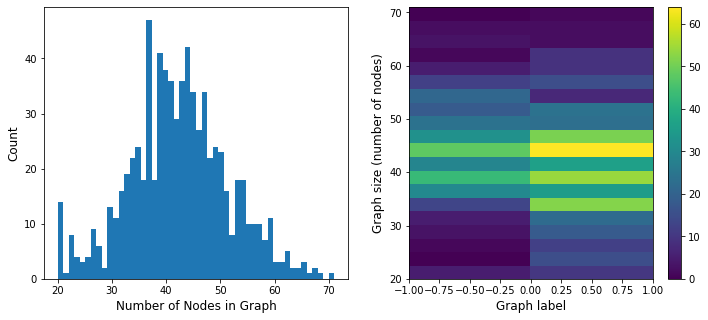

Correlation between graph size (number of nodes) and labels: -0.16


In [ ]:
GetNodeDistribution("DHFR")

Extracting dataset  PTC_FM..
Parsing dataset  PTC_FM..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
VISUALIZATIONS:
Max nodes in consideration: 64


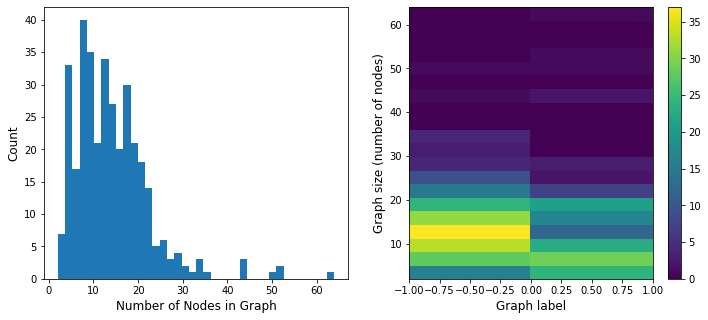

Correlation between graph size (number of nodes) and labels: -0.08


In [ ]:
GetNodeDistribution("PTC_FM")

Extracting dataset  PTC_FR..
Parsing dataset  PTC_FR..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
VISUALIZATIONS:
Max nodes in consideration: 64


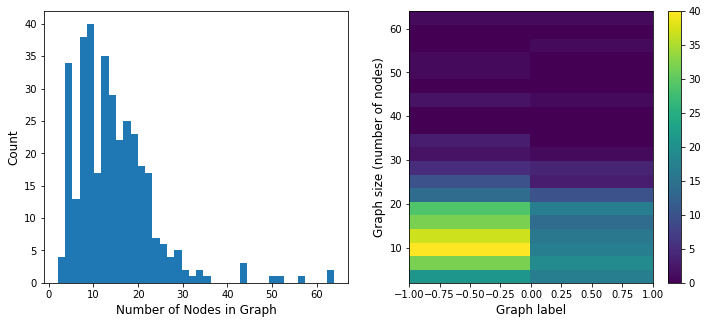

Correlation between graph size (number of nodes) and labels: -0.03


In [ ]:
GetNodeDistribution("PTC_FR")

Extracting dataset  PTC_MM..
Parsing dataset  PTC_MM..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
VISUALIZATIONS:
Max nodes in consideration: 64


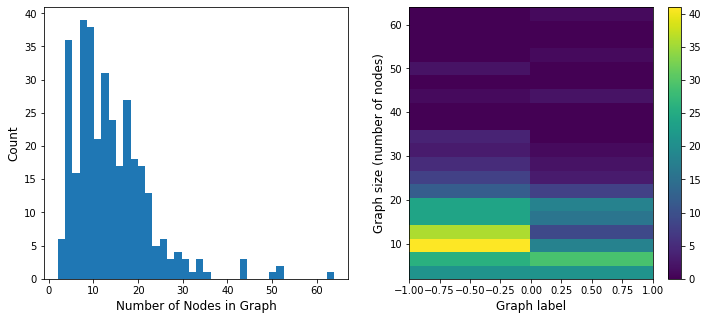

Correlation between graph size (number of nodes) and labels: -0.06


In [ ]:
GetNodeDistribution("PTC_MM")

Extracting dataset  PTC_MR..
Parsing dataset  PTC_MR..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
VISUALIZATIONS:
Max nodes in consideration: 64


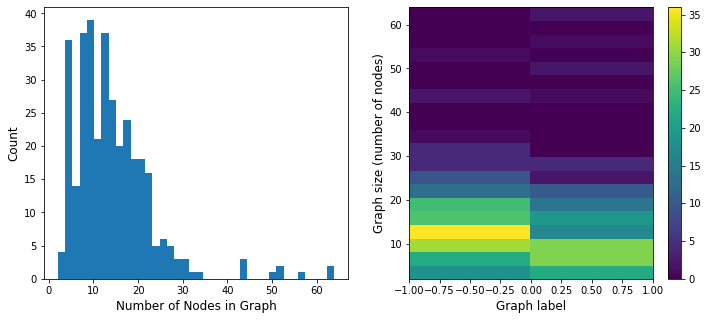

Correlation between graph size (number of nodes) and labels: -0.06


In [ ]:
GetNodeDistribution("PTC_MR")

Extracting dataset  IMDB-BINARY..
Parsing dataset  IMDB-BINARY..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
VISUALIZATIONS:
Max nodes in consideration: 136


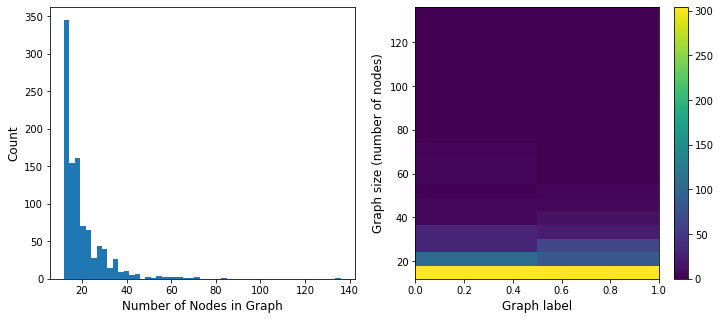

Correlation between graph size (number of nodes) and labels: -0.03


In [ ]:
GetNodeDistribution("IMDB-BINARY")

Extracting dataset  MSRC_9..
Parsing dataset  MSRC_9..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
VISUALIZATIONS:
Max nodes in consideration: 55


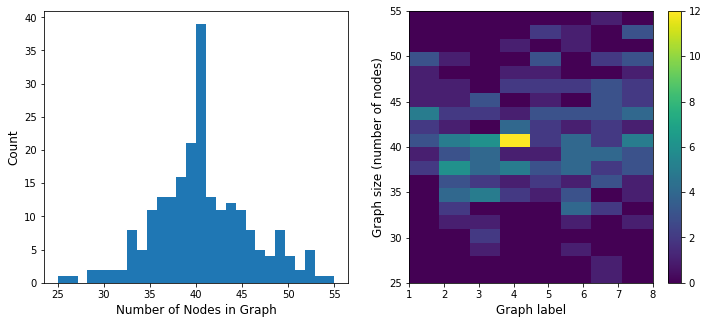

Correlation between graph size (number of nodes) and labels: 0.11


In [ ]:
GetNodeDistribution("MSRC_9")

Extracting dataset  MSRC_21..
Parsing dataset  MSRC_21..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
VISUALIZATIONS:
Max nodes in consideration: 141


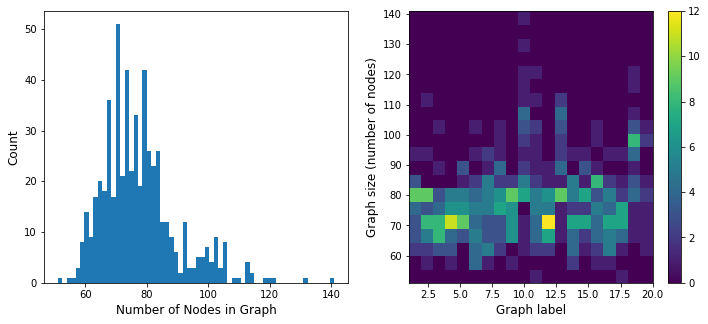

Correlation between graph size (number of nodes) and labels: 0.19


In [ ]:
GetNodeDistribution("MSRC_21")

Extracting dataset  MSRC_21C..
Parsing dataset  MSRC_21C..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
VISUALIZATIONS:
Max nodes in consideration: 57


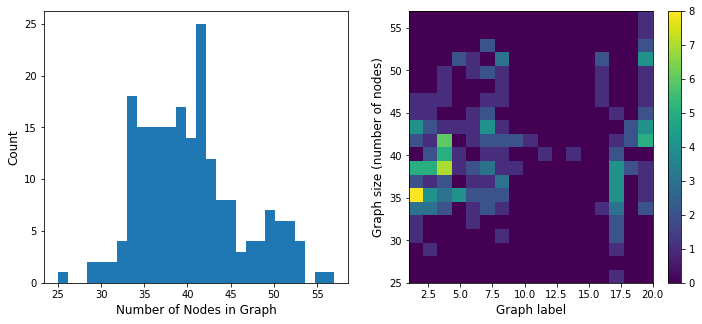

Correlation between graph size (number of nodes) and labels: 0.18


In [ ]:
GetNodeDistribution("MSRC_21C")

# Isomorphic Matrix and Number.

## without Label

In [ ]:
['BZR', 'COX2', 'DHFR', 'PTC_FM', 'PTC_FR', 'PTC_MM', 'PTC_MR','IMDB-BINARY', 'MSRC_9', 'MSRC_21', 'MSRC_21C']

Extracting dataset  BZR..
Parsing dataset  BZR..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
there are  491.0 pairs of graphs isomorphiced
done in 29.867s



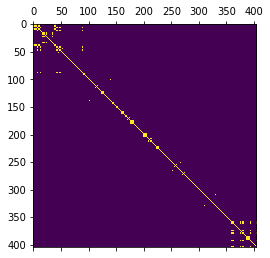

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("BZR", False, False)
print("done in %0.3fs\n" % (time.time() - t0))

Extracting dataset  COX2..
Parsing dataset  COX2..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
there are  655.0 pairs of graphs isomorphiced
done in 93.473s



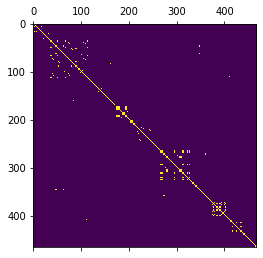

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("COX2", False, False)
print("done in %0.3fs\n" % (time.time() - t0))

Extracting dataset  DHFR..
Parsing dataset  DHFR..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
there are  409.0 pairs of graphs isomorphiced
done in 163.218s



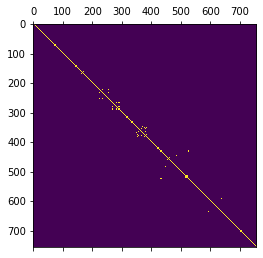

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("DHFR", False, False)
print("done in %0.3fs\n" % (time.time() - t0))

Extracting dataset  PTC_FM..
Parsing dataset  PTC_FM..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
there are  238.0 pairs of graphs isomorphiced
done in 3.557s



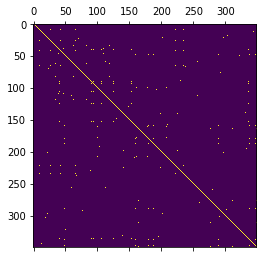

In [ ]:
t0 = time.time()

DrawIsomorphicMatrix("PTC_FM", False, False)
print("done in %0.3fs\n" % (time.time() - t0))

Extracting dataset  PTC_MM..
Parsing dataset  PTC_MM..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
there are  257.0 pairs of graphs isomorphiced
done in 3.552s



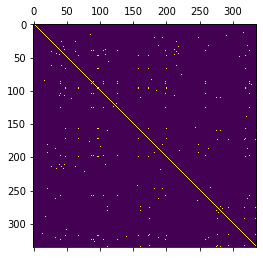

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("PTC_MM", False, False)
print("done in %0.3fs\n" % (time.time() - t0))

Extracting dataset  PTC_MR..
Parsing dataset  PTC_MR..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
there are  243.0 pairs of graphs isomorphiced
done in 3.791s



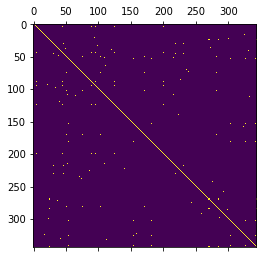

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("PTC_MR", False, False)
print("done in %0.3fs\n" % (time.time() - t0))

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("IMDB-BINARY", False, False)
print("done in %0.3fs\n" % (time.time() - t0))

Extracting dataset  MSRC_9..
Parsing dataset  MSRC_9..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
there are  0.0 pairs of graphs isomorphiced
done in 4.430s



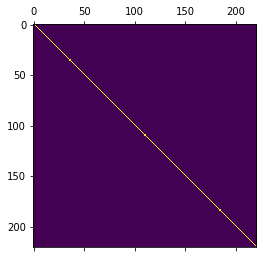

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("MSRC_9", False, False)
print("done in %0.3fs\n" % (time.time() - t0))

Extracting dataset  MSRC_21..
Parsing dataset  MSRC_21..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
there are  0.0 pairs of graphs isomorphiced
done in 38.411s



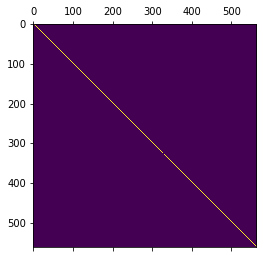

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("MSRC_21", False, False)
print("done in %0.3fs\n" % (time.time() - t0))

Extracting dataset  MSRC_21C..
Parsing dataset  MSRC_21C..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
there are  0.0 pairs of graphs isomorphiced
done in 3.853s



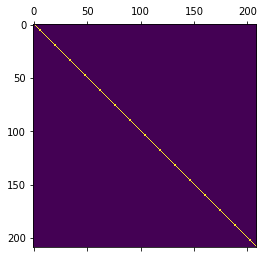

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("MSRC_21C", False, False)
print("done in %0.3fs\n" % (time.time() - t0))

Extracting dataset  SYNTHETIC..
Parsing dataset  SYNTHETIC..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
there are  44850.0 pairs of graphs isomorphiced
done in 4316.377s



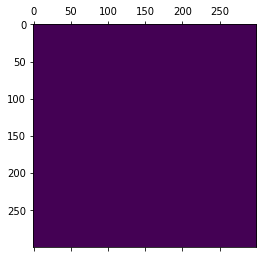

In [114]:

t0 = time.time()
DrawIsomorphicMatrix("SYNTHETIC", False, False)
print("done in %0.3fs\n" % (time.time() - t0))

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("DHFR", True, False)
print("done in %0.3fs\n" % (time.time() - t0))

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("PTC_FM", True, False)
print("done in %0.3fs\n" % (time.time() - t0))

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("PTC_FR", True, False)
print("done in %0.3fs\n" % (time.time() - t0))

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("PTC_MM", True, False)
print("done in %0.3fs\n" % (time.time() - t0))

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("PTC_MR", True, False)
print("done in %0.3fs\n" % (time.time() - t0))

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("IMDB-BINARY", True, False)
print("done in %0.3fs\n" % (time.time() - t0))

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("MSRC_9", True, False)
print("done in %0.3fs\n" % (time.time() - t0))

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("MSRC_21", True, False)
print("done in %0.3fs\n" % (time.time() - t0))

In [ ]:
t0 = time.time()
DrawIsomorphicMatrix("MSRC_2C", True, False)
print("done in %0.3fs\n" % (time.time() - t0))